In [ ]:
!nvidia-smi

Fri Jan 27 21:35:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-0dgjj7if
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-0dgjj7if
  Resolved https://github.com/albu/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=839091d8ba8e6b87504778dc309d7884443bdd3185cafa5d6cd3e207fe6fee8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-cy50527p/wheels/c5/ca/df/fae131e2d3a8174cd8668f10bf0591fa158f0824214d3017bc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import albumentations as A
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os

In [ ]:
!curl -L "https://public.roboflow.com/ds/h2pFCsbfx1?key=JTwGr4En7D" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0    830      0  0:00:01  0:00:01 --:--:--   829
100 4006k  100 4006k    0     0  1505k      0  0:00:02  0:00:02 --:--:-- 5848k
Archive:  roboflow.zip
 extracting: test/the-first-day-of-wuhan-s-closure-some-people-fled-some-panicked_jpg.rf.0302fefb0879eb37736a704ca5d070ff.jpg  
 extracting: train/thumbnail-ba5c72edb320b49a69e86b05775c49b2-scaled-1_jpeg.rf.035d587add7bc2a6c7616d72e56bfad4.jpg  
 extracting: train/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a82b03b6f60106_jpg.rf.104bedd5b3bad4a0d0a453203e0617a3.jpg  
 extracting: test/phplpE73q_jpg.rf.bd81cab9f8ff2674ce2e58278f7d37fa.jpg  
 extracting: train/ST_20190917_SPTHAZE_5120715_jpg.rf.09fb2eecb2449a63f1f239f5fbb713aa.jpg  
 extracting: test/RTX7CCFN_jpg.rf.66ed5c5054f30d933d19ab3d56ace004.jpg  
 extracting: test/w1240-p16x9-0e48e0098f6e832f27d8b581b33

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from PIL import Image
import os
import os.path
from typing import Any, Callable, Optional, Tuple, List
import torchvision.transforms.functional as F

class MaskDetection(torch.utils.data.Dataset):

    def __init__(
        self,
        root: str,
        annFile: str,
        transforms: Optional[Callable] = None,
    ):
        # super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        targets = {}
        targets['boxes'] = torch.tensor([item['bbox'] for item in target])#.view(-1, 4)
        targets['labels'] = torch.tensor([item['category_id'] for item in target])#.view(-1)

        if self.transforms is not None:
          image = F.to_tensor(image).permute(1, 2, 0).numpy()
          transformed = transform(image=image, bboxes=targets['boxes'], category_ids=targets['labels'])

        image = torch.tensor(transformed['image']).permute(2, 0, 1)
        targets['boxes'] = torch.tensor(transformed['bboxes'])

        if targets['boxes'].numel() > 0:
            
            targets['area'] = targets['boxes'][:, 2] * targets['boxes'][:, 3]
            targets['boxes'][:, 2] += targets['boxes'][:, 0]
            targets['boxes'][:, 3] += targets['boxes'][:, 1]
            targets['labels'] = torch.tensor(transformed['category_ids'])
            targets['image_id'] = torch.tensor(target[0]['image_id'])
            targets['iscrowd'] = torch.tensor([item['iscrowd'] for item in target])
        else:
            targets = {}

        return image, targets

    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.9),
                       A.ShiftScaleRotate(p=0.9),
                       A.RandomBrightness(p=0.3)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1146: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
def get_loader(root, json, transform=None, batch_size=1, shuffle=False, num_workers=4):
    dataset = MaskDetection(root=root,
                       annFile=json,
                       transforms=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=new_concat)
    return data_loader, dataset

In [ ]:
trainloader, trainset = get_loader('train', '/content/train/_annotations.coco.json', shuffle=True, transform=transform)

testloader, testset = get_loader('test', '/content/test/_annotations.coco.json', shuffle=True, transform=transform)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
batch = next(iter(trainloader))

In [ ]:
batch[0], batch[1]

((tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
           [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
           [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
           ...,
           [0.9961, 0.9961, 0.9961,  ..., 0.2902, 0.5725, 1.0000],
           [0.9843, 0.9843, 0.9882,  ..., 0.2902, 0.6157, 1.0000],
           [0.9961, 0.9961, 0.9961,  ..., 0.2941, 0.6392, 1.0000]],
  
          [[1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
           [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
           [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.2510, 0.5333, 0.9765],
           [0.9922, 0.9922, 0.9961,  ..., 0.2510, 0.5765, 0.9882],
           [1.0000, 1.0000, 1.0000,  ..., 0.2549, 0.6000, 0.9882]],
  
          [[1.0000, 1.0000, 1.0000,  ..., 0.7451, 0.7451, 0.7451],
           [1.0000, 1.0000, 1.0000,  ..., 0.7451, 0.7451, 0.7451],
           [1.0000, 1.

In [ ]:
images = [image.to(device) for image in batch[0]]
targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

In [ ]:
images

[tensor([[[0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          ...,
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805]],
 
         [[0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          ...,
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805]],
 
         [[0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ...,

In [ ]:
targets

[{'boxes': tensor([[367.0000,  72.0000, 414.0000, 136.0000],
          [170.0000, 123.0000, 237.0000, 220.0000],
          [243.0000, 128.0000, 304.0000, 212.0000],
          [114.0000,  75.0000, 175.0000, 166.0000]], device='cuda:0',
         dtype=torch.float64),
  'labels': tensor([2, 2, 1, 1], device='cuda:0'),
  'area': tensor([3007.9986, 6499.0006, 5123.9978, 5550.9997], device='cuda:0',
         dtype=torch.float64),
  'image_id': tensor(102, device='cuda:0'),
  'iscrowd': tensor([0, 0, 0, 0], device='cuda:0')}]

In [ ]:
net = torchvision.models.detection.retinanet_resnet50_fpn(True)
net.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import sys
import logging
from torch.utils.tensorboard import SummaryWriter
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('FineTune')
# logger.setLevel(logging.INFO)
writer = SummaryWriter()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
logging.info('test')

INFO:root:test


In [ ]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 287345, done.
remote: Counting objects: 100% (8471/8471), done.
remote: Compressing objects: 100% (554/554), done.
remote: Total 287345 (delta 7988), reused 8341 (delta 7899), pack-reused 278874
Receiving objects: 100% (287345/287345), 575.94 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (263113/263113), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # inputs, targets = inputs.to(device), targets.to(device)
        inputs = [image.to(device) for image in inputs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(targets[0]['image_id'])
        optimizer.zero_grad()
        loss_dict = net(inputs, targets)
        loss = sum(loss for loss in loss_dict.values())
        # loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_total.update(loss)
        # accuracy(outputs.softmax(dim=-1), targets)
        # print(targets[:10])
        # if batch_idx == 20:
        #     break
        scheduler.step()
    # acc = accuracy.compute()
    writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    # writer.add_scalar('Acc/train', acc.item(), epoch)
    logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
    # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
    

def test(epoch, checkpoint):
    net.eval()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            inputs = [image.to(device) for image in inputs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = net(inputs)
            # loss = criterion(outputs, targets)
            # loss_total.update(loss)
            # accuracy(outputs.softmax(dim=-1), targets)
        # acc = accuracy.compute()
        # writer.add_scalar('Loss/test', loss_total.avg.item(), epoch)
        # writer.add_scalar('Acc/test', acc.item(), epoch)
        # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
        # logger.info(f'Test:  Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
        print()
    # Save checkpoint
    # checkpoint.save(accuracy.compute(), epoch=epoch)


class Checkpoint(object):
    def __init__(self, model_name):
        self.best_acc = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, epoch=-1):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [ ]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt-retina-dar-detection')
start, end = 0, 10
for epoch in range(start, end):
    train(epoch)
    # test(epoch, checkpoint)
    evaluate(net, testloader, device=device)

writer.close()

tensor(14, device='cuda:0')
tensor(8, device='cuda:0')
tensor(1, device='cuda:0')
tensor(5, device='cuda:0')
tensor(7, device='cuda:0')
tensor(4, device='cuda:0')
tensor(9, device='cuda:0')
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')
tensor(11, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(12, device='cuda:0')
tensor(13, device='cuda:0')
tensor(6, device='cuda:0')


INFO:FineTune:Train: Epoch:0 Loss:0.455


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:12  model_time: 0.1000 (0.1000)  evaluator_time: 0.0228 (0.0228)  time: 0.4370  data: 0.3125  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0913 (0.0929)  evaluator_time: 0.0139 (0.0195)  time: 0.1238  data: 0.0081  max mem: 1649
Test: Total time: 0:00:03 (0.1375 s / it)
Averaged stats: model_time: 0.0913 (0.0929)  evaluator_time: 0.0139 (0.0195)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:1 Loss:0.4825


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:14  model_time: 0.0935 (0.0935)  evaluator_time: 0.0781 (0.0781)  time: 0.4946  data: 0.3173  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0915 (0.0917)  evaluator_time: 0.0083 (0.0127)  time: 0.1082  data: 0.0043  max mem: 1649
Test: Total time: 0:00:03 (0.1247 s / it)
Averaged stats: model_time: 0.0915 (0.0917)  evaluator_time: 0.0083 (0.0127)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:2 Loss:0.3862


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:11  model_time: 0.1286 (0.1286)  evaluator_time: 0.0028 (0.0028)  time: 0.3924  data: 0.2589  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0904 (0.0923)  evaluator_time: 0.0107 (0.0122)  time: 0.1110  data: 0.0042  max mem: 1649
Test: Total time: 0:00:03 (0.1230 s / it)
Averaged stats: model_time: 0.0904 (0.0923)  evaluator_time: 0.0107 (0.0122)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:3 Loss:0.3962


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:10  model_time: 0.1080 (0.1080)  evaluator_time: 0.0114 (0.0114)  time: 0.3663  data: 0.2451  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0901 (0.0913)  evaluator_time: 0.0058 (0.0107)  time: 0.1050  data: 0.0042  max mem: 1649
Test: Total time: 0:00:03 (0.1203 s / it)
Averaged stats: model_time: 0.0901 (0.0913)  evaluator_time: 0.0058 (0.0107)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:4 Loss:0.3079


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:13  model_time: 0.1021 (0.1021)  evaluator_time: 0.0423 (0.0423)  time: 0.4497  data: 0.3033  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0903 (0.0909)  evaluator_time: 0.0064 (0.0112)  time: 0.1068  data: 0.0042  max mem: 1649
Test: Total time: 0:00:03 (0.1223 s / it)
Averaged stats: model_time: 0.0903 (0.0909)  evaluator_time: 0.0064 (0.0112)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:5 Loss:0.3369


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:11  model_time: 0.1162 (0.1162)  evaluator_time: 0.0023 (0.0023)  time: 0.3853  data: 0.2650  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0896 (0.0917)  evaluator_time: 0.0055 (0.0347)  time: 0.1053  data: 0.0047  max mem: 1649
Test: Total time: 0:00:04 (0.1458 s / it)
Averaged stats: model_time: 0.0896 (0.0917)  evaluator_time: 0.0055 (0.0347)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:6 Loss:0.2969


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:12  model_time: 0.1396 (0.1396)  evaluator_time: 0.0093 (0.0093)  time: 0.4140  data: 0.2633  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0890 (0.0915)  evaluator_time: 0.0047 (0.0103)  time: 0.1067  data: 0.0041  max mem: 1649
Test: Total time: 0:00:03 (0.1204 s / it)
Averaged stats: model_time: 0.0890 (0.0915)  evaluator_time: 0.0047 (0.0103)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:7 Loss:0.3482


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:12  model_time: 0.0900 (0.0900)  evaluator_time: 0.0109 (0.0109)  time: 0.4350  data: 0.3324  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0894 (0.0896)  evaluator_time: 0.0079 (0.0113)  time: 0.1078  data: 0.0042  max mem: 1649
Test: Total time: 0:00:03 (0.1220 s / it)
Averaged stats: model_time: 0.0894 (0.0896)  evaluator_time: 0.0079 (0.0113)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:8 Loss:0.3195


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:11  model_time: 0.0982 (0.0982)  evaluator_time: 0.0026 (0.0026)  time: 0.3938  data: 0.2911  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0897 (0.0904)  evaluator_time: 0.0039 (0.0089)  time: 0.1056  data: 0.0041  max mem: 1649
Test: Total time: 0:00:03 (0.1189 s / it)
Averaged stats: model_time: 0.0897 (0.0904)  evaluator_time: 0.0039 (0.0089)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:9 Loss:0.2804


creating index...
index created!
Test:  [ 0/29]  eta: 0:00:10  model_time: 0.0999 (0.0999)  evaluator_time: 0.0052 (0.0052)  time: 0.3750  data: 0.2680  max mem: 1649
Test:  [28/29]  eta: 0:00:00  model_time: 0.0900 (0.0903)  evaluator_time: 0.0076 (0.0116)  time: 0.1046  data: 0.0042  max mem: 1649
Test: Total time: 0:00:03 (0.1211 s / it)
Averaged stats: model_time: 0.0900 (0.0903)  evaluator_time: 0.0076 (0.0116)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.022
 Average Recall     (AR) @[ IoU=

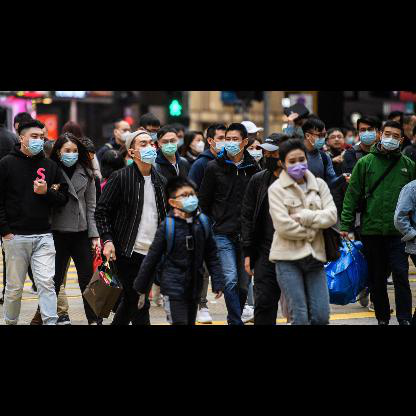

In [ ]:
from PIL import Image

img_pil = Image.open('/content/t/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a82b03b6f60106_jpg.rf.104bedd5b3bad4a0d0a453203e0617a3.jpg').convert('RGB')
display(img_pil)

In [ ]:
img_tensor = torchvision.transforms.functional.to_tensor(img_pil)
list_img = [img_tensor.to(device)]

net.eval()
with torch.no_grad():
  predictions = net(list_img)

predictions

[{'boxes': tensor([[  9.9520, 110.7387,  51.5268, 159.4934],
          [375.6342, 115.6853, 407.3584, 155.0381],
          [ 52.2641, 130.5925,  86.0569, 167.8567],
          [353.4137, 113.3438, 383.3760, 146.3293],
          [222.2802, 119.7984, 251.7126, 157.2966],
          [154.6799, 121.7959, 186.9580, 158.6679],
          [161.1033, 172.6069, 204.2356, 217.7047],
          [275.5096, 135.8593, 315.5087, 183.1445],
          [296.4758, 110.9574, 332.0011, 152.3308],
          [123.5240, 126.3851, 161.7932, 167.1985],
          [243.0619, 134.7175, 266.6900, 163.4815],
          [202.9156, 119.6381, 230.4593, 156.3065],
          [109.0602, 115.6752, 135.0648, 145.9212],
          [136.6345, 110.0681, 164.4222, 142.6829],
          [184.0248, 127.4342, 209.6676, 155.8889],
          [323.1996, 123.8387, 348.5257, 152.0626],
          [342.6677, 125.0407, 362.1286, 146.9403],
          [258.3760, 129.4682, 288.7958, 163.2459],
          [331.3147, 123.8169, 357.7097, 150.2282],
   

In [ ]:
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].to(device).cpu()
scores = predictions[0]['scores'].to(device).cpu()

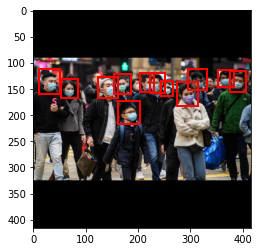

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np_arr = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score > 0.7:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)

    ax.add_patch(rect)

plt.show()